# More Advanced CNN Model: CIFAR-10
------------------

In this example, we will download the CIFAR-10 images and build a CNN model with dropout and regularization.

CIFAR is composed ot 50k train and 10k test images that are 32x32.

We start by loading the necessary libaries and resetting any default computational graph that already exists.

In [2]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops
ops.reset_default_graph()

Next, start a new graph session and set the default parameters.

List of defaults:

 - `batch_size`: this is how many cifar examples to train on in one batch.
 - `data_dir`: where to store data (check if data exists here, as to not have to download every time).
 - `output_every`: output training accuracy/loss statistics every X generations/epochs.
 - `eval_every`: output test accuracy/loss statistics every X generations/epochs.
 - `image_height`: standardize images to this height.
 - `image_width`: standardize images to this width.
 - `crop_height`: random internal crop before training on image - height.
 - `crop_width`: random internal crop before training on image - width.
 - `num_channels`: number of color channels of image (greyscale = 1, color = 3).
 - `num_targets`: number of different target categories. CIFAR-10 has 10.
 - `extract_folder`: folder to extract downloaded images to.

In [3]:
# Start a graph session
sess = tf.Session()

# Set model parameters
batch_size = 128
data_dir = 'temp'
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

Set the learning rate, learning rate decay parameters, and extract some of the image-model parameters.

In [4]:
# Exponential Learning Rate Decay Params
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.

# Extract model parameters
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length # ( + 1 for the 0-9 label)

Load the CIFAR-10 data.

In [5]:
# Load data
data_dir = 'temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

# Check if file exists, otherwise download it
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

Next, we define a reading function that will load (and optionally distort the images slightly) for training.

In [6]:
# Define CIFAR reader
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
  
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]),
                                 [num_channels, image_height, image_width])
    
    # Reshape image
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    
    if distort_images:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        final_image = tf.image.random_contrast(final_image,lower=0.2, upper=1.8)

    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image)
    return final_image, image_label

Use the above loading function in our image pipeline function below.

In [7]:
# Create a CIFAR image pipeline from reader
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    # min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    # capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image, label],
                                                        batch_size=batch_size,
                                                        capacity=capacity,
                                                        min_after_dequeue=min_after_dequeue)

    return example_batch, label_batch

Create a function that returns our CIFAR-10 model architecture so that we can use it both for training and testing.

In [8]:
# Define the model architecture, this will return logits from images
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    def truncated_normal_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.truncated_normal_initializer(stddev=0.05)))
    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        # Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name='conv_kernel1', shape=[5, 5, 3, 64], dtype=tf.float32)
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias term
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        # ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool_layer1')
    
    # Local Response Normalization (parameters from paper)
    # paper: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')

    # Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 64], dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    
    # Max Pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')    
    
     # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    # Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    # First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))

    # Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))

    # Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope('full3') as scope:
        # Final fully connected layer has 10 (num_targets) outputs.
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 =  zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return final_output

Define our loss function.  Our loss will be the average cross entropy loss (categorical loss).

In [9]:
# Loss function
def cifar_loss(logits, targets):
    # Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    # Take the average loss across batch size
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return cross_entropy_mean

Define our training step.  Here we will use exponential decay of the learning rate, declare the optimizer and tell the training step to minimize the loss.

In [10]:
# Train step
def train_step(loss_value, generation_num):
    # Our learning rate is an exponential decay after we wait a fair number of generations
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num,
                                                     num_gens_to_wait, lr_decay, staircase=True)
    # Create optimizer
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    # Initialize train step
    train_step = my_optimizer.minimize(loss_value)
    return train_step

Create an accuracy function that takes in the predicted logits from the model and the actual targets and returns the accuracy for recording statistics on the train/test sets.

In [11]:
# Accuracy function
def accuracy_of_batch(logits, targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions, targets)
    # Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return accuracy

Now that we have all our functions we need, let's use them to create

  1. our data pipeline
  
  2. our model
  
  3. the evaluations/accuracy/training operations.

First our data pipeline:

In [12]:
# Get data
print('Getting/Transforming Data.')
# Initialize the data pipeline
images, targets = input_pipeline(batch_size, train_logical=True)
# Get batch test images and targets from pipline
test_images, test_targets = input_pipeline(batch_size, train_logical=False)

Getting/Transforming Data.


Create our model.

Note: Be careful not to accidentally run the following model-creation code twice without resetting the computational graph.  If you do, you will end up with variable-sharing errors.  If that is the case, re-run the whole script.

In [13]:
# Declare Model
print('Creating the CIFAR10 Model.')
with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images, batch_size)
    # This is very important!!!  We must set the scope to REUSE the variables,
    #  otherwise, when we set the test network model, it will create new random
    #  variables.  Otherwise we get random evaluations on the test batches.
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)
print('Done.')

Creating the CIFAR10 Model.
Done.


Loss and accuracy functions:

In [14]:
# Declare loss function
print('Declare Loss Function.')
loss = cifar_loss(model_output, targets)

# Create accuracy function
accuracy = accuracy_of_batch(test_output, test_targets)

Declare Loss Function.


Next, create the training operations and initialize our model variables.

In [15]:
# Create training operations
print('Creating the Training Operation.')
generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

# Initialize Variables
print('Initializing the Variables.')
init = tf.global_variables_initializer()
sess.run(init)

Creating the Training Operation.
Initializing the Variables.


Now, we initialize our data queue.  This is an operation that will feed data into our model. Because of this _no placeholders are necessary_!!

In [16]:
# Initialize queue (This queue will feed into the model, so no placeholders necessary)
tf.train.start_queue_runners(sess=sess)

[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 140554214045440)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 140554205652736)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 140554176296704)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 140553878501120)>]

Training our CIFAR-10 model.

In [17]:
# Train CIFAR Model
print('Starting Training')
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)
    
    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy = {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

Starting Training
Generation 50: Loss = 2.22219
Generation 100: Loss = 1.85807
Generation 150: Loss = 1.68547
Generation 200: Loss = 1.68184
Generation 250: Loss = 1.74119
Generation 300: Loss = 1.38158
Generation 350: Loss = 1.65851
Generation 400: Loss = 1.40172
Generation 450: Loss = 1.57229
Generation 500: Loss = 1.52364
 --- Test Accuracy = 48.44%.
Generation 550: Loss = 1.54652
Generation 600: Loss = 1.21434
Generation 650: Loss = 1.15258
Generation 700: Loss = 1.40707
Generation 750: Loss = 1.22228
Generation 800: Loss = 1.63065
Generation 850: Loss = 0.99193
Generation 900: Loss = 1.22815
Generation 950: Loss = 1.32409
Generation 1000: Loss = 1.15603
 --- Test Accuracy = 61.72%.
Generation 1050: Loss = 1.18986
Generation 1100: Loss = 1.29607
Generation 1150: Loss = 1.06038
Generation 1200: Loss = 1.08335
Generation 1250: Loss = 0.92217
Generation 1300: Loss = 1.07797
Generation 1350: Loss = 0.98897
Generation 1400: Loss = 0.90099
Generation 1450: Loss = 1.15199
Generation 1500:

Generation 11800: Loss = 0.08673
Generation 11850: Loss = 0.15599
Generation 11900: Loss = 0.23680
Generation 11950: Loss = 0.20358
Generation 12000: Loss = 0.12177
 --- Test Accuracy = 76.56%.
Generation 12050: Loss = 0.08545
Generation 12100: Loss = 0.09663
Generation 12150: Loss = 0.10876
Generation 12200: Loss = 0.09189
Generation 12250: Loss = 0.24599
Generation 12300: Loss = 0.15975
Generation 12350: Loss = 0.10316
Generation 12400: Loss = 0.11794
Generation 12450: Loss = 0.13761
Generation 12500: Loss = 0.14217
 --- Test Accuracy = 77.34%.
Generation 12550: Loss = 0.08080
Generation 12600: Loss = 0.16124
Generation 12650: Loss = 0.12760
Generation 12700: Loss = 0.11007
Generation 12750: Loss = 0.12987
Generation 12800: Loss = 0.15755
Generation 12850: Loss = 0.12064
Generation 12900: Loss = 0.14124
Generation 12950: Loss = 0.09701
Generation 13000: Loss = 0.10831
 --- Test Accuracy = 78.12%.
Generation 13050: Loss = 0.07502
Generation 13100: Loss = 0.12954
Generation 13150: Loss

Plot the loss and accuracy.

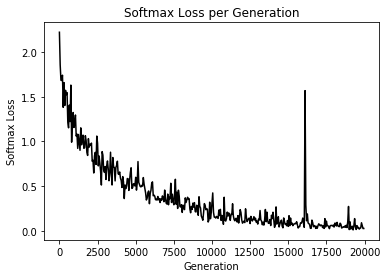

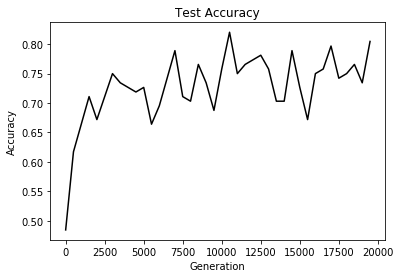

In [18]:
# Print loss and accuracy
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

# Plot loss over time
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot accuracy over time
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()